# Modelado de una epidemia basado en agentes y formación de oscilaciones

**Integrantes**: Lautaro Lasorsa, Nicolás Letterio, Nicolás Rozenberg, Facundo Solar

Modelado de Sistemas Complejos con Aplicaciones a Economía

1er Cuatrimestre 2024

Duración estimada de la ejecución: 45 min

## Puntos a cubrir

1. Introducción y descripción del modelo
    - Arquitectura
    - Dinámica
    - Parámetros de control
    - Hiperparámetros
2. Sobre la variación en el tamaño de la población
3. Sobre la variación en el factor de miedo en los individuos
4. Planteando un modelo simulando en grupos
    - Variando parámetros de la función de miedo
    - Crear oscilaciones
    - Cuando ya hay oscilaciones

5. Consideraciones a futuro    

## 1. Introducción y descripción del modelo

La pregunta que mediante modelado y simulación buscamos tratar es cómo bajo el contexto de una epidemia se forman oscilaciones en variables agregadas que describen a la sociedad, y cómo cambian de acuerdo a fenómenos sociales bajo distintas caracterizaciones fijas tanto a nivel sociedad como individuo.

Como primer modelo para la epidemia planteamos inicialmente un modelo SEIS (Susceptible, Expuesto infeccioso, Infectado, Susceptible), donde modelamos las asistencias de cada uno de los individuos con las actividades que realizan, mediante una arquitectura en grafos y modelando el riesgo en ambientes cerrados. Esto es en contraposición a los modelos clásicos Mean Field, que en general modelan las epidemias mediante ecuaciones diferenciales.

### Arquitectura

![Red_bipartita.png](./Red_bipartita.png)

- Grafo bipartito pesado.
- Parte izquierda representa a los individuos que interactúan en una economía cerrada en un contexto epidemiológico (N nodos).
- Parte derecha representan entidades donde los individuos pueden realizar actividades de consumo indoor, como pueden ser acudir a un restaurante, ir al gimnasio, etc. (M nodos)  
- El peso de los arcos representará el puntaje de satisfacción que le asigna el individuo a acudir a una determinada entidad.
- Para determinar los arcos, primero se creará una matriz aleatoria de n x m al inicializar el modelo con una distribución lognormal(0, 1) y con un umbral de corte bajo el cual se considera que no hay arco.
- Si existe el arco i -> j, queda como peso el valor de la entrada (i, j) de la matriz normalizada de acuerdo a la suma total de valores para el individuo i.

### Dinámica

- Tiempo discreto.
- Inicialmente, todos los individuos están en estado Susceptible salvo una parte de la población, que se encuentra en estado Expuesto infeccioso.
- Los individuos poseen información global acerca del número total de infectados el día anterior, y memoria acerca de los días anteriores.

$$
riesgo_{t+1}=memoria*riesgo_{t} + (1-memoria)*\frac{infectados\_reportados_{t}}{N}
$$

- Si un individuo se encuentra en estado Susceptible o Expuesto infeccioso, intentará a asistir a la mayor cantidad de lugares posible. No asistirá si el riesgo que le supone ir a un determinado lugar sobrepasa su tolerancia al riesgo. Acude con la siguiente ecuación:

$$acude_{i,e,t} \leftrightarrow riesgo_t * satisfaccion_{i,e}< tol_i$$

- Un individuo que asiste a un determinado lugar j en un turno tiene una probabilidad de contagiarse basada en el modelo de distribución exponencial de Wiles-Riley (1978)

$$
P = 1 - e^{-\frac{Iqpt}{QV}}
$$

- $I$ son los infectores
- $t$ es el tiempo que ha permanecido una persona en un lugar
- $q$: La tasa a la que una persona infectada libera partículas infecciosas en el aire.
- $Q$: La tasa a la que se suministra aire limpio a la habitación, lo que ayuda a diluir la concentración de partículas infecciosas.
- $p$: El volumen de aire inhalado por una persona susceptible por unidad de tiempo.

Nosotros consideraremos

$$
P_{Contagio_j}(t) = 1 - e^{-\frac{1}{\beta} \frac{(I_j(t) + E_j(t))}{Asistentes_j(t)}}
$$

$\frac{1}{\beta}$ es una constante que agrupa todos los factores que no dependen de los infectores. La supondremos constante para cualquier escenario. Es decir, suponemos que los individuos están una cantidad de tiempo fija y constante, y que las demás condiciones ocurren de igual manera para todo sitio.

### Parámetros de Control

- N: Tamaño de la población
- max_tolerancia_riesgo: La máxima tolerancia al riesgo que puede poseer un individuo.

### Hiperparámetros

- M: Número de entidades que participan en la economía, a las cuales puede acudir presencialmente un individuo (constante).
- til_base: Tiempo base que dura el período de enfermedad en latencia.
- tic_base: Tiempo base que dura el periodo de enfermedad contagiosa.
- memoria: Coeficiente que se utiliza para actualizar el riesgo percibido para realizar una determinada actividad. (0 <= memoria < 1)
- umbral: Umbral de corte de satisfacción para inicializar el grafo.

In [15]:
from simulacion_red import SimulacionRed
from simulacion_agrupada import SimulacionAgrupada
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import textwrap

In [16]:
def PlotSimulacion(
        ax1,
        ax2,
        titulo : str,
        historial_infectados : list[int],
        historial_satisfaccion : list[float],
        historial_asistencias : list[int],
        simulacion : SimulacionRed,
):
    ax1.plot(historial_infectados, label='Infectados')
    ax1.plot(historial_satisfaccion, label='Satisfacción')
    asistencias_posibles = len(simulacion.asistencias_posibles())
    ax1.plot([x/asistencias_posibles * simulacion.n for x in historial_asistencias], label='Asistencias')
    ax1.legend()

    m_infectados = max(historial_infectados)
    ax2.plot([x/m_infectados for x in historial_infectados], label = "Infectados reescalados (1 = maximo de infectados)")

    ax1.set_title(titulo)
    ax2.set_title(titulo)

    ax2.legend()

    ax1.set_xlabel("Tiempo")
    ax2.set_xlabel("Tiempo")

## 2. Sobre la variación en el tamaño de la población

- En poblaciones más chicas, cada asistencia tiene mayor peso sobre la dinámica general. Por lo tanto, hay mayor ruido, y la dinámica se diferencia más del modelo Mean Field.

- Hay que ajustar el tamaño de la población para llegar a un escenario donde el modelo se estabilice a lo esperable analíticamente

In [17]:
M = 20   # Número de entidades
tiempo = 1000
til_base = 5
tic_base = 5
memoria = 0.5
umbral = 4
contagiosidad = 0.1
max_tolerancia_riesgo = 1e99 # anular el factor del miedo
expuestos_iniciales = 5

- Parametro a modificar para llegar a la situación estable

$N$ : Cantidad de personas

In [18]:
def Generar_Escenario_N(N) -> tuple[str, list[int], list[int], list[int], SimulacionRed]:
    np.random.seed(123456)
    simulacion = SimulacionRed(N, M, til_base, tic_base, memoria, max_tolerancia_riesgo, umbral, fun_contagio = lambda expuestos, asistencias: 1-math.exp(-contagiosidad * expuestos/(asistencias)), initial_exposeds = expuestos_iniciales)
    historial_infectados, historial_satisfaccion, historial_asistencias = simulacion.ejecutar_simulacion(tiempo)
    titulo = f"Simulación con N = {N}"
    return titulo, historial_infectados, historial_satisfaccion, historial_asistencias, simulacion

In [29]:
Ns = [100, 200, 500, 1000, 2000, 10000] #, 1000, 2000, 10000]
np.random.seed(150603)
random.seed(150603)
resultados = [Generar_Escenario_N(N) for N in Ns]

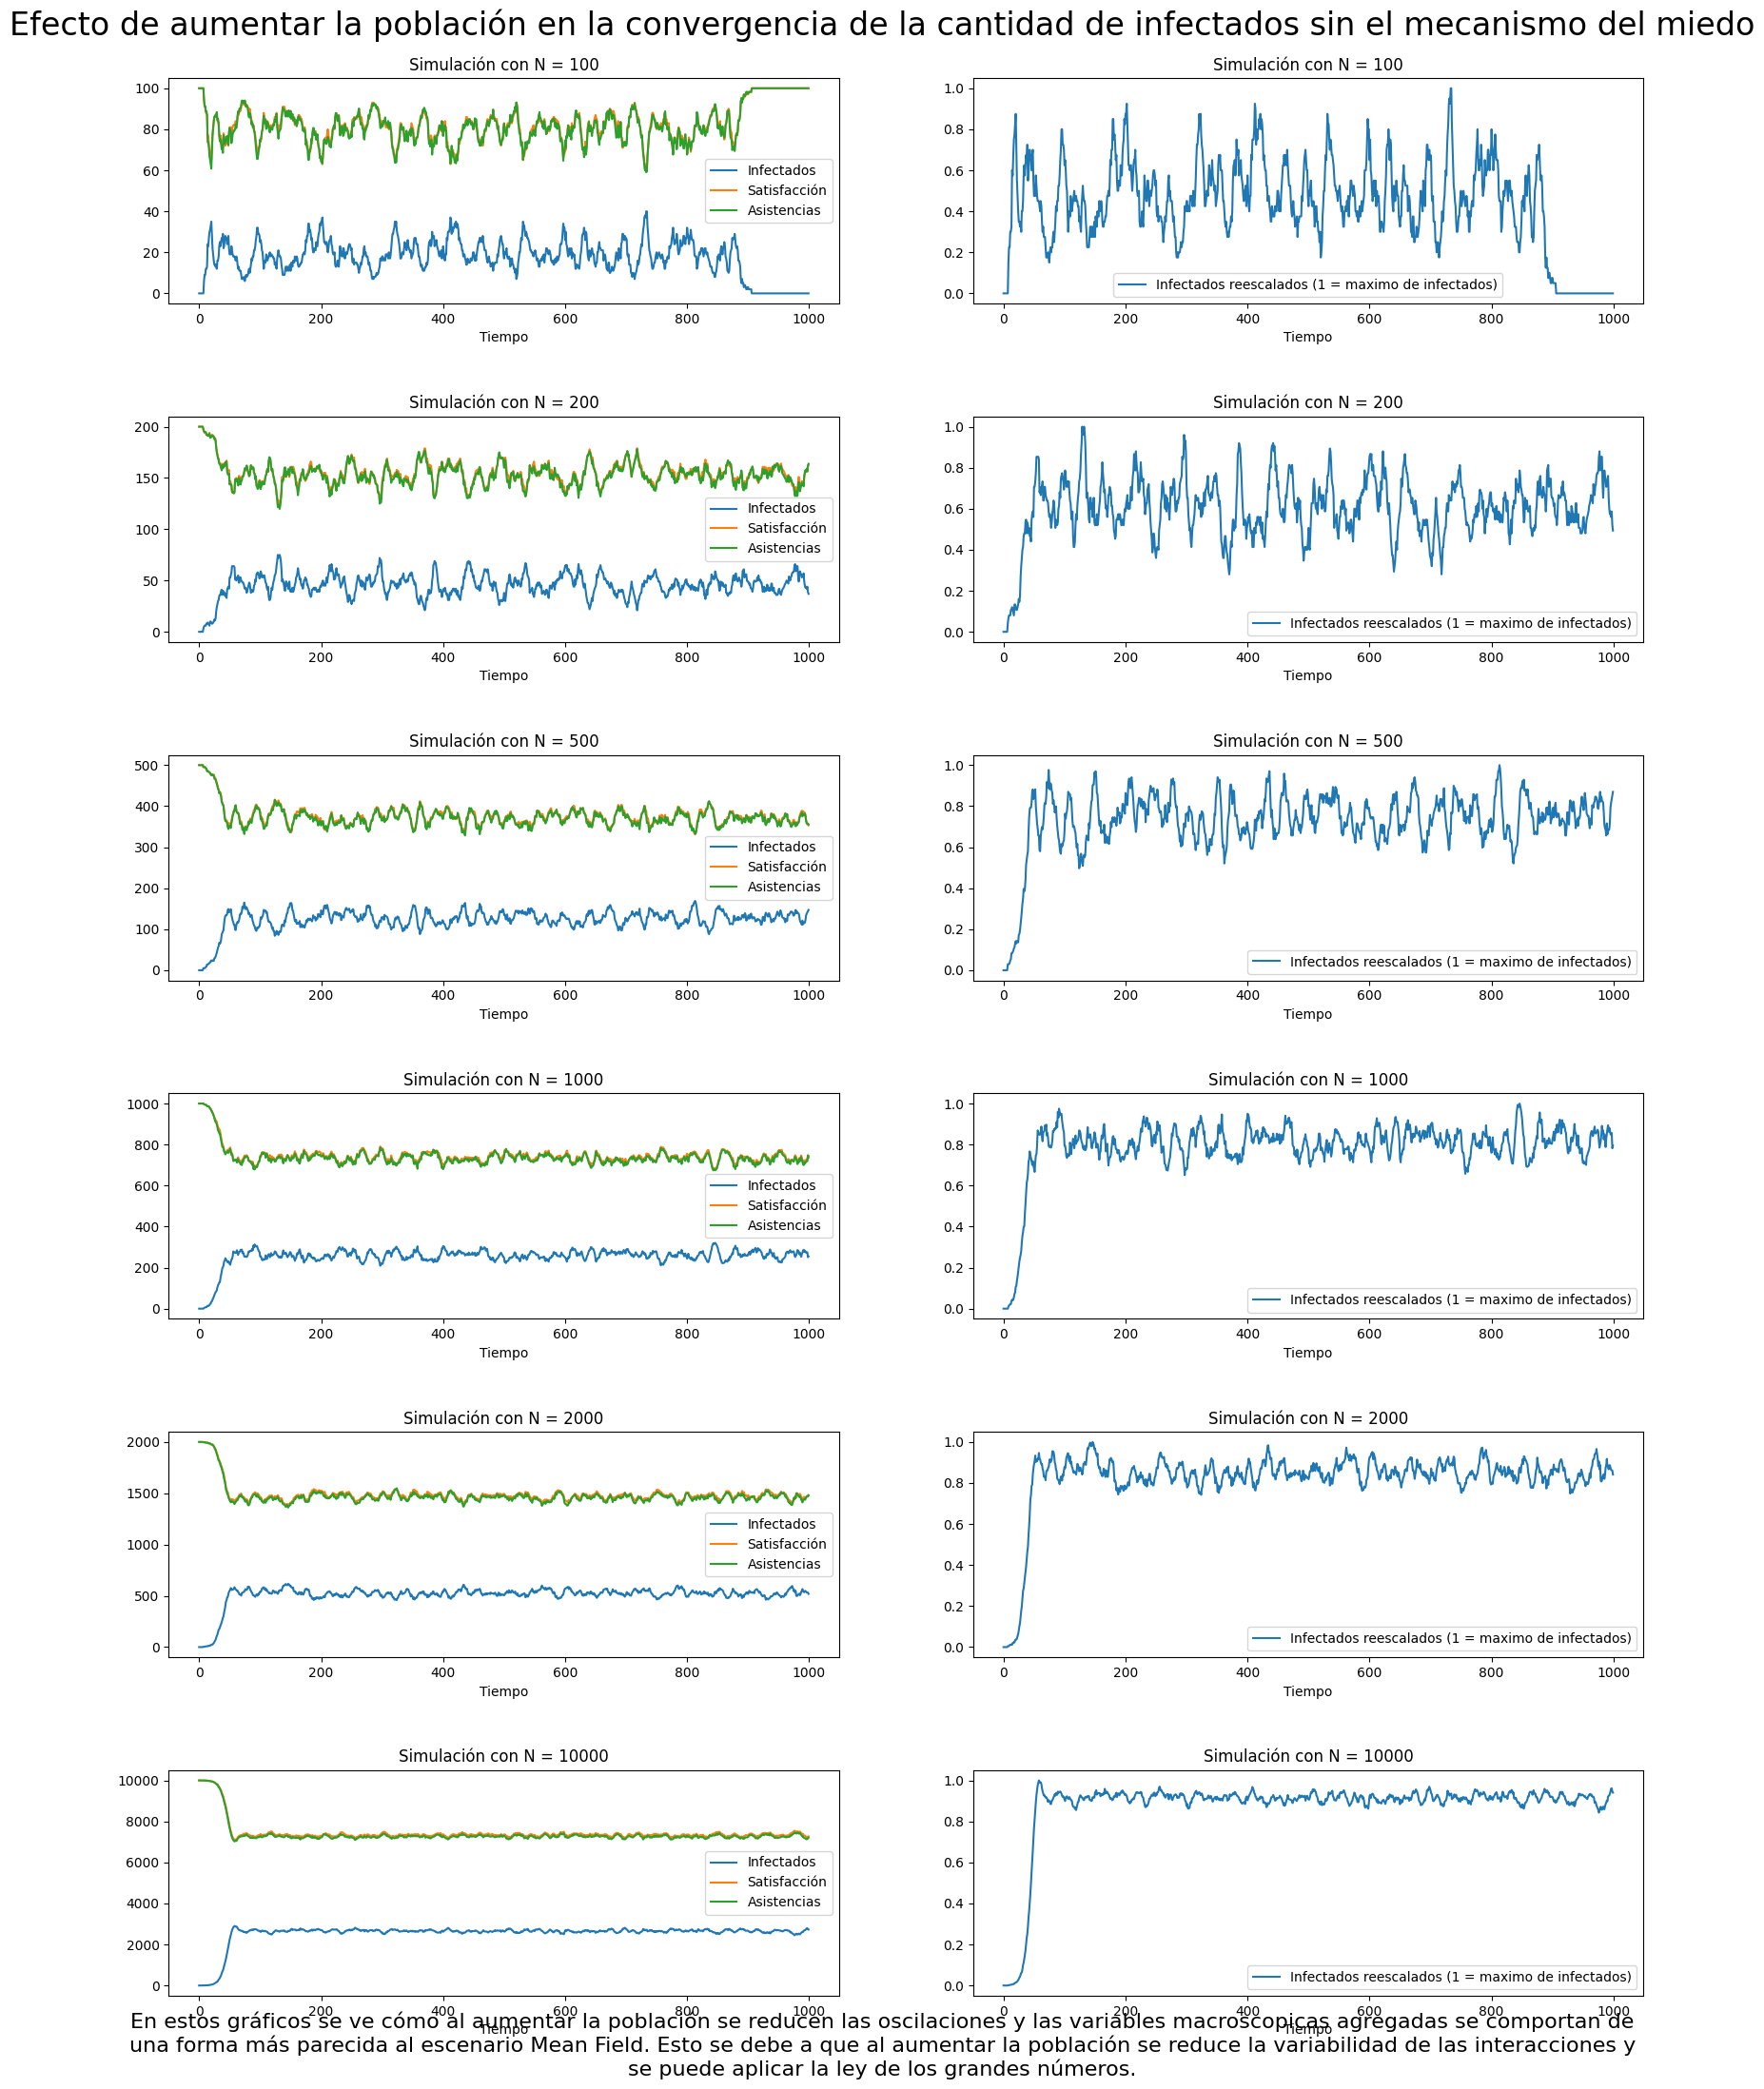

In [30]:
fig, ax = plt.subplots(nrows=len(Ns), ncols=2, figsize=(20, 4 * len(Ns)), gridspec_kw={'hspace': 0.5})
descripcion = 'En estos gráficos se ve cómo al aumentar la población se reducen las oscilaciones y las variables macroscopicas agregadas se comportan de una forma más parecida al escenario Mean Field. Esto se debe a que al aumentar la población se reduce la variabilidad de las interacciones y se puede aplicar la ley de los grandes números.'
descripcion = textwrap.fill(descripcion, width=140)
fig.text(0.5, 0.075,descripcion , ha='center', fontsize=16,)
fig.suptitle('Efecto de aumentar la población en la convergencia de la cantidad de infectados sin el mecanismo del miedo', fontsize=24)
fig.subplots_adjust(top=0.95)  # Adjust the top spacing
for i, resultado in enumerate(resultados):
    PlotSimulacion(ax[i, 0], ax[i, 1], *resultado)
plt.show()


## 3. Incorporando el miedo

Parámetros fijos

In [31]:
N = 10000
M = 20   # Número de entidades
tiempo = 1000
til_base = 5
tic_base = 5
memoria = 0.5
umbral = 4
contagiosidad = 0.1
expuestos_iniciales = 5

Parámetro de control a modificar

$max\_toleracia\_riesgo$ : Máxima tolerancia de un individuo al riesgo

Función que corre un escenario

In [32]:
def Probar_Escenario_Riesgo(max_tolerancia_riesgo):
    simulacion = SimulacionRed(N, M, til_base, tic_base, memoria, max_tolerancia_riesgo, umbral, fun_contagio = lambda expuestos, asistencias: 1-math.exp(-contagiosidad * expuestos/(asistencias)))
    historial_infectados, historial_satisfaccion, historial_asistencias = simulacion.ejecutar_simulacion(tiempo)
    if max_tolerancia_riesgo > 1e90:
        titulo = f"Simulación sin mecanismo del miedo"
    else:
        titulo = f"Simulación con max_tolerancia_riesgo = {max_tolerancia_riesgo}"
    return titulo, historial_infectados, historial_satisfaccion, historial_asistencias, simulacion

In [35]:
max_tolerancia_riesgos = [1e99, 1, 0.01, 0.001, 0.0005, 0.000375, 0.00025, 0.0001]
np.random.seed(150603)
random.seed(150603)
resultados_riesgo = [Probar_Escenario_Riesgo(max_tolerancia_riesgo) for max_tolerancia_riesgo in max_tolerancia_riesgos]

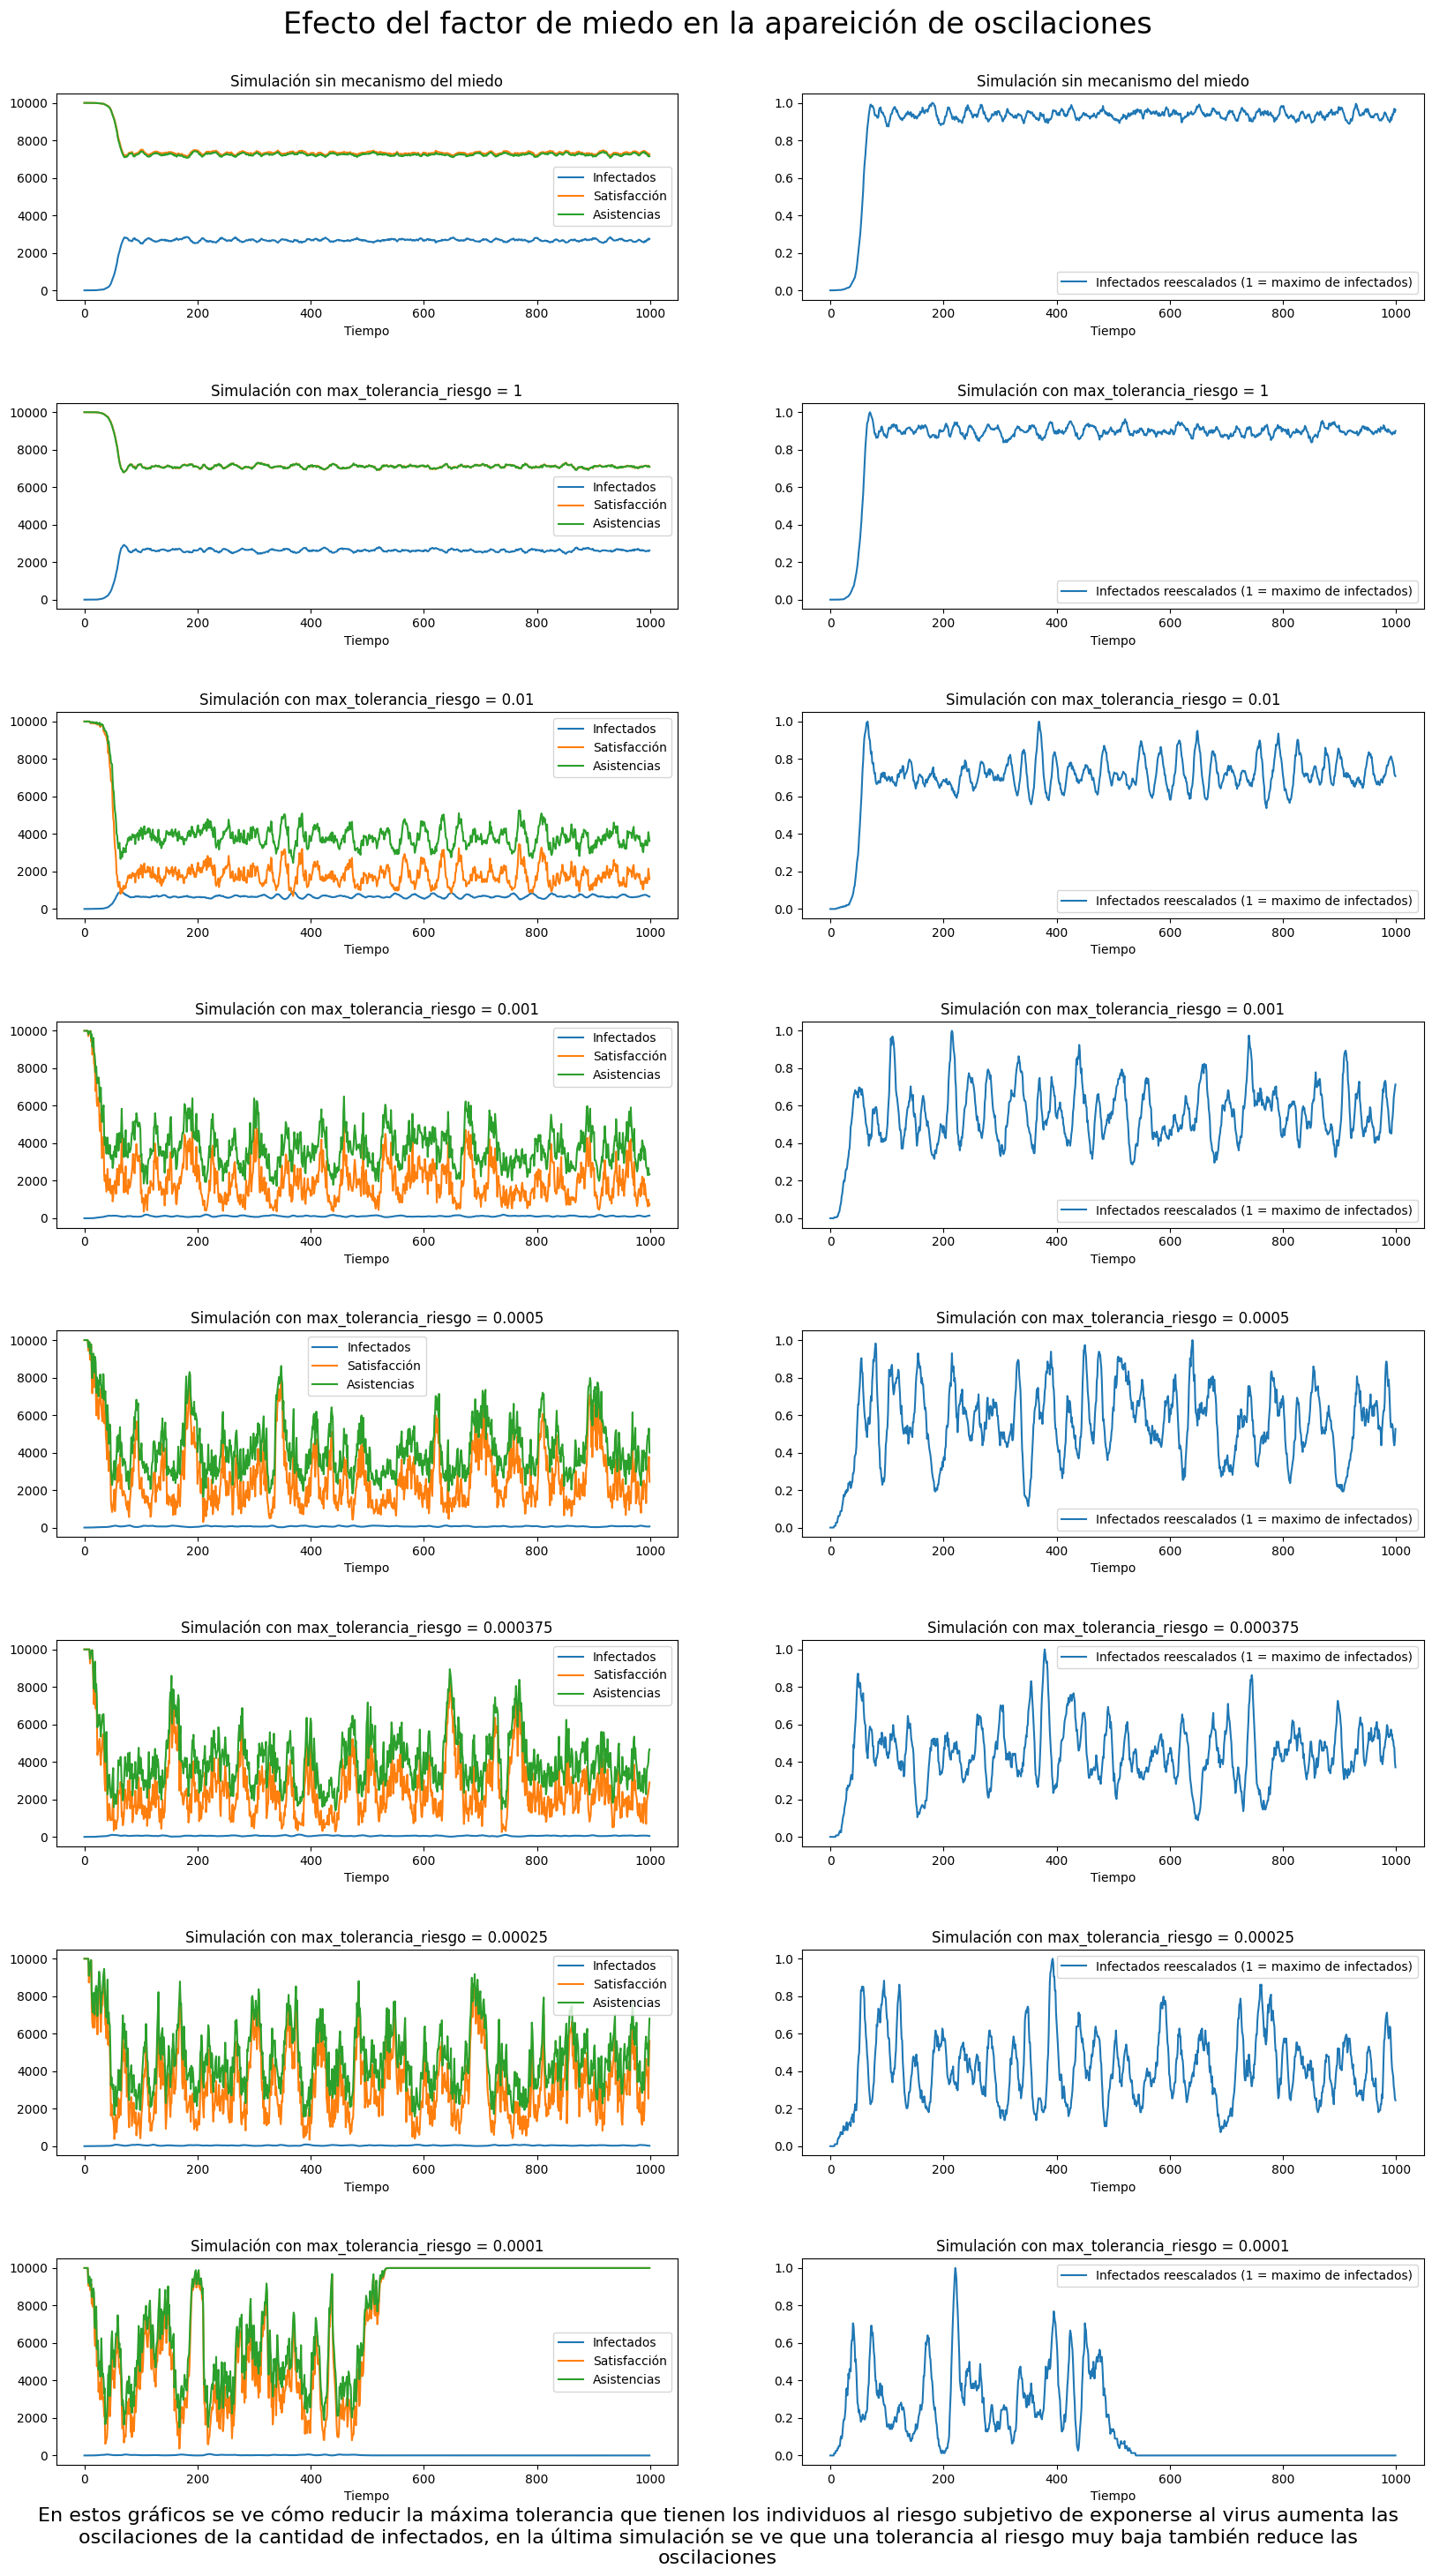

In [36]:
fig, ax = plt.subplots(nrows=len(max_tolerancia_riesgos), ncols=2, figsize=(20, 4 * len(max_tolerancia_riesgos)), gridspec_kw={'hspace': 0.5})
descripcion = 'En estos gráficos se ve cómo reducir la máxima tolerancia que tienen los individuos al riesgo subjetivo de exponerse al virus aumenta las oscilaciones de la cantidad de infectados, en la última simulación se ve que una tolerancia al riesgo muy baja también reduce las oscilaciones'
descripcion = textwrap.fill(descripcion, width=140)
fig.suptitle('Efecto del factor de miedo en la apareición de oscilaciones', fontsize=24)
fig.text(0.5, 0.075,descripcion , ha='center', fontsize=16,)
fig.subplots_adjust(top=0.95)  # Adjust the top spacing
for i, resultado in enumerate(resultados_riesgo):
    PlotSimulacion(ax[i, 0], ax[i, 1], *resultado)
plt.show()

## 4. Planteando un modelo simulando en grupos

Vamos a considerar otro modelo. Para considerar situaciones en poblaciones muy grandes, donde la asistencia de cada individuo a cada actividad es independiente de su asistencia a las demás actividades, podemos construir un modelo donde agrupamos a las personas por el conjunto de actividades a las que asisten. Es decir, no vamos a modelar las asistencias individuales de cada persona. Buscamos crear una aproximación mean field al modelo anterior.

Por cada subconjunto de actividad que existe, modelamos un grupo de personas.

In [56]:
def PlotSimulacionAgrupada(
        ax1,
        ax2,
        titulo : str,
        simulacion : SimulacionAgrupada,
):
    ax1.plot(simulacion.infc_total, label = ("Expuestos", "Infectados"))
    ax1.legend(fontsize = 12)
    ax1.set_title(titulo, fontsize = 20)
    ax1.set_ylim(0,1)

    ax2.set_title(titulo, fontsize = 20)
    ax2.plot(simulacion.asistencias, label = ("Valuntad de asistir","Asistencia"))
    ax2.legend(fontsize = 12)
    ax2.set_ylim(0,1)


Parámetros fijos

In [57]:
probs = [0.9, 0.7, 0.5, 0.3, 0.1, 0.1, 0.1, 0.1]
prob_inicial = 1e-6
etoi = 1/14
itos = 1/7
memoria = 0
info_global = True
alfa_miedo = 1
beta_contagio = 1
n_dias = 500


Funciones parametrizadas

Para este nuevo modelo, cambiaremos la función de miedo de cada día:

$ e^{-{casos\_nuevos}^{\alpha_{miedo}} * \beta_{miedo}} $

$\alpha_{miedo}$ y $\beta_{miedo}$ son dos parámetros de la función de miedo sin un significado específico


Esto se debe a que queremos modelar el miedo que posee un grupo de individuos, en vez del miedo individual. Queremos ver qué proporción de los pertenecientes al grupo va a asistir a sus actividades.



In [58]:
def gen_fun_miedo(memoria : float, alfa : float, beta : float ):
    def fun_miedo(casos : list[tuple[float,float]]) -> float:
        asistencia = 1
        for (exp, inf) in casos[-14:-7]:
            asistencia = asistencia * memoria + (1-memoria)*np.exp(- (exp*etoi) ** alfa * beta)
        return asistencia
    return fun_miedo

def gen_fun_contagio(beta : float):
    def fun_contagio(sanos : float, expuestos : float, asistencia : float) -> float:
        return asistencia * np.exp(-expuestos/(beta * (1+expuestos+sanos)))
    return fun_contagio

Explicación de la salida:
* Expuestos: Proporción de la población que está expuesta a la infección
* Infectados: Proporción de la población que está infectada (y lo sabe)
* Voluntad de asistir: Proporción de la población sana que asiste a sus activiades.
* Asistencia: Proporción de la población total que asiste a sus actividades (es igual a Volutad de asistir * (1-Infectados))

### Escenarios $\alpha_{miedo} = 1$

In [59]:
def Generar_Escenario_Beta_Miedo(beta_miedo):
    simulacion = SimulacionAgrupada(probs, etoi, itos, prob_inicial, gen_fun_miedo(memoria, alfa_miedo, beta_miedo), gen_fun_contagio(beta_contagio), info_global)
    simulacion.AvanzarHastaT(n_dias)
    titulo = f"Simulación con beta_miedo = {beta_miedo}"
    return titulo, simulacion

In [60]:
betas_miedo = [1, 10, 100, 200, 400, 800, 2000]
np.random.seed(123456)
resultados_beta_miedo = [Generar_Escenario_Beta_Miedo(beta_miedo) for beta_miedo in betas_miedo]

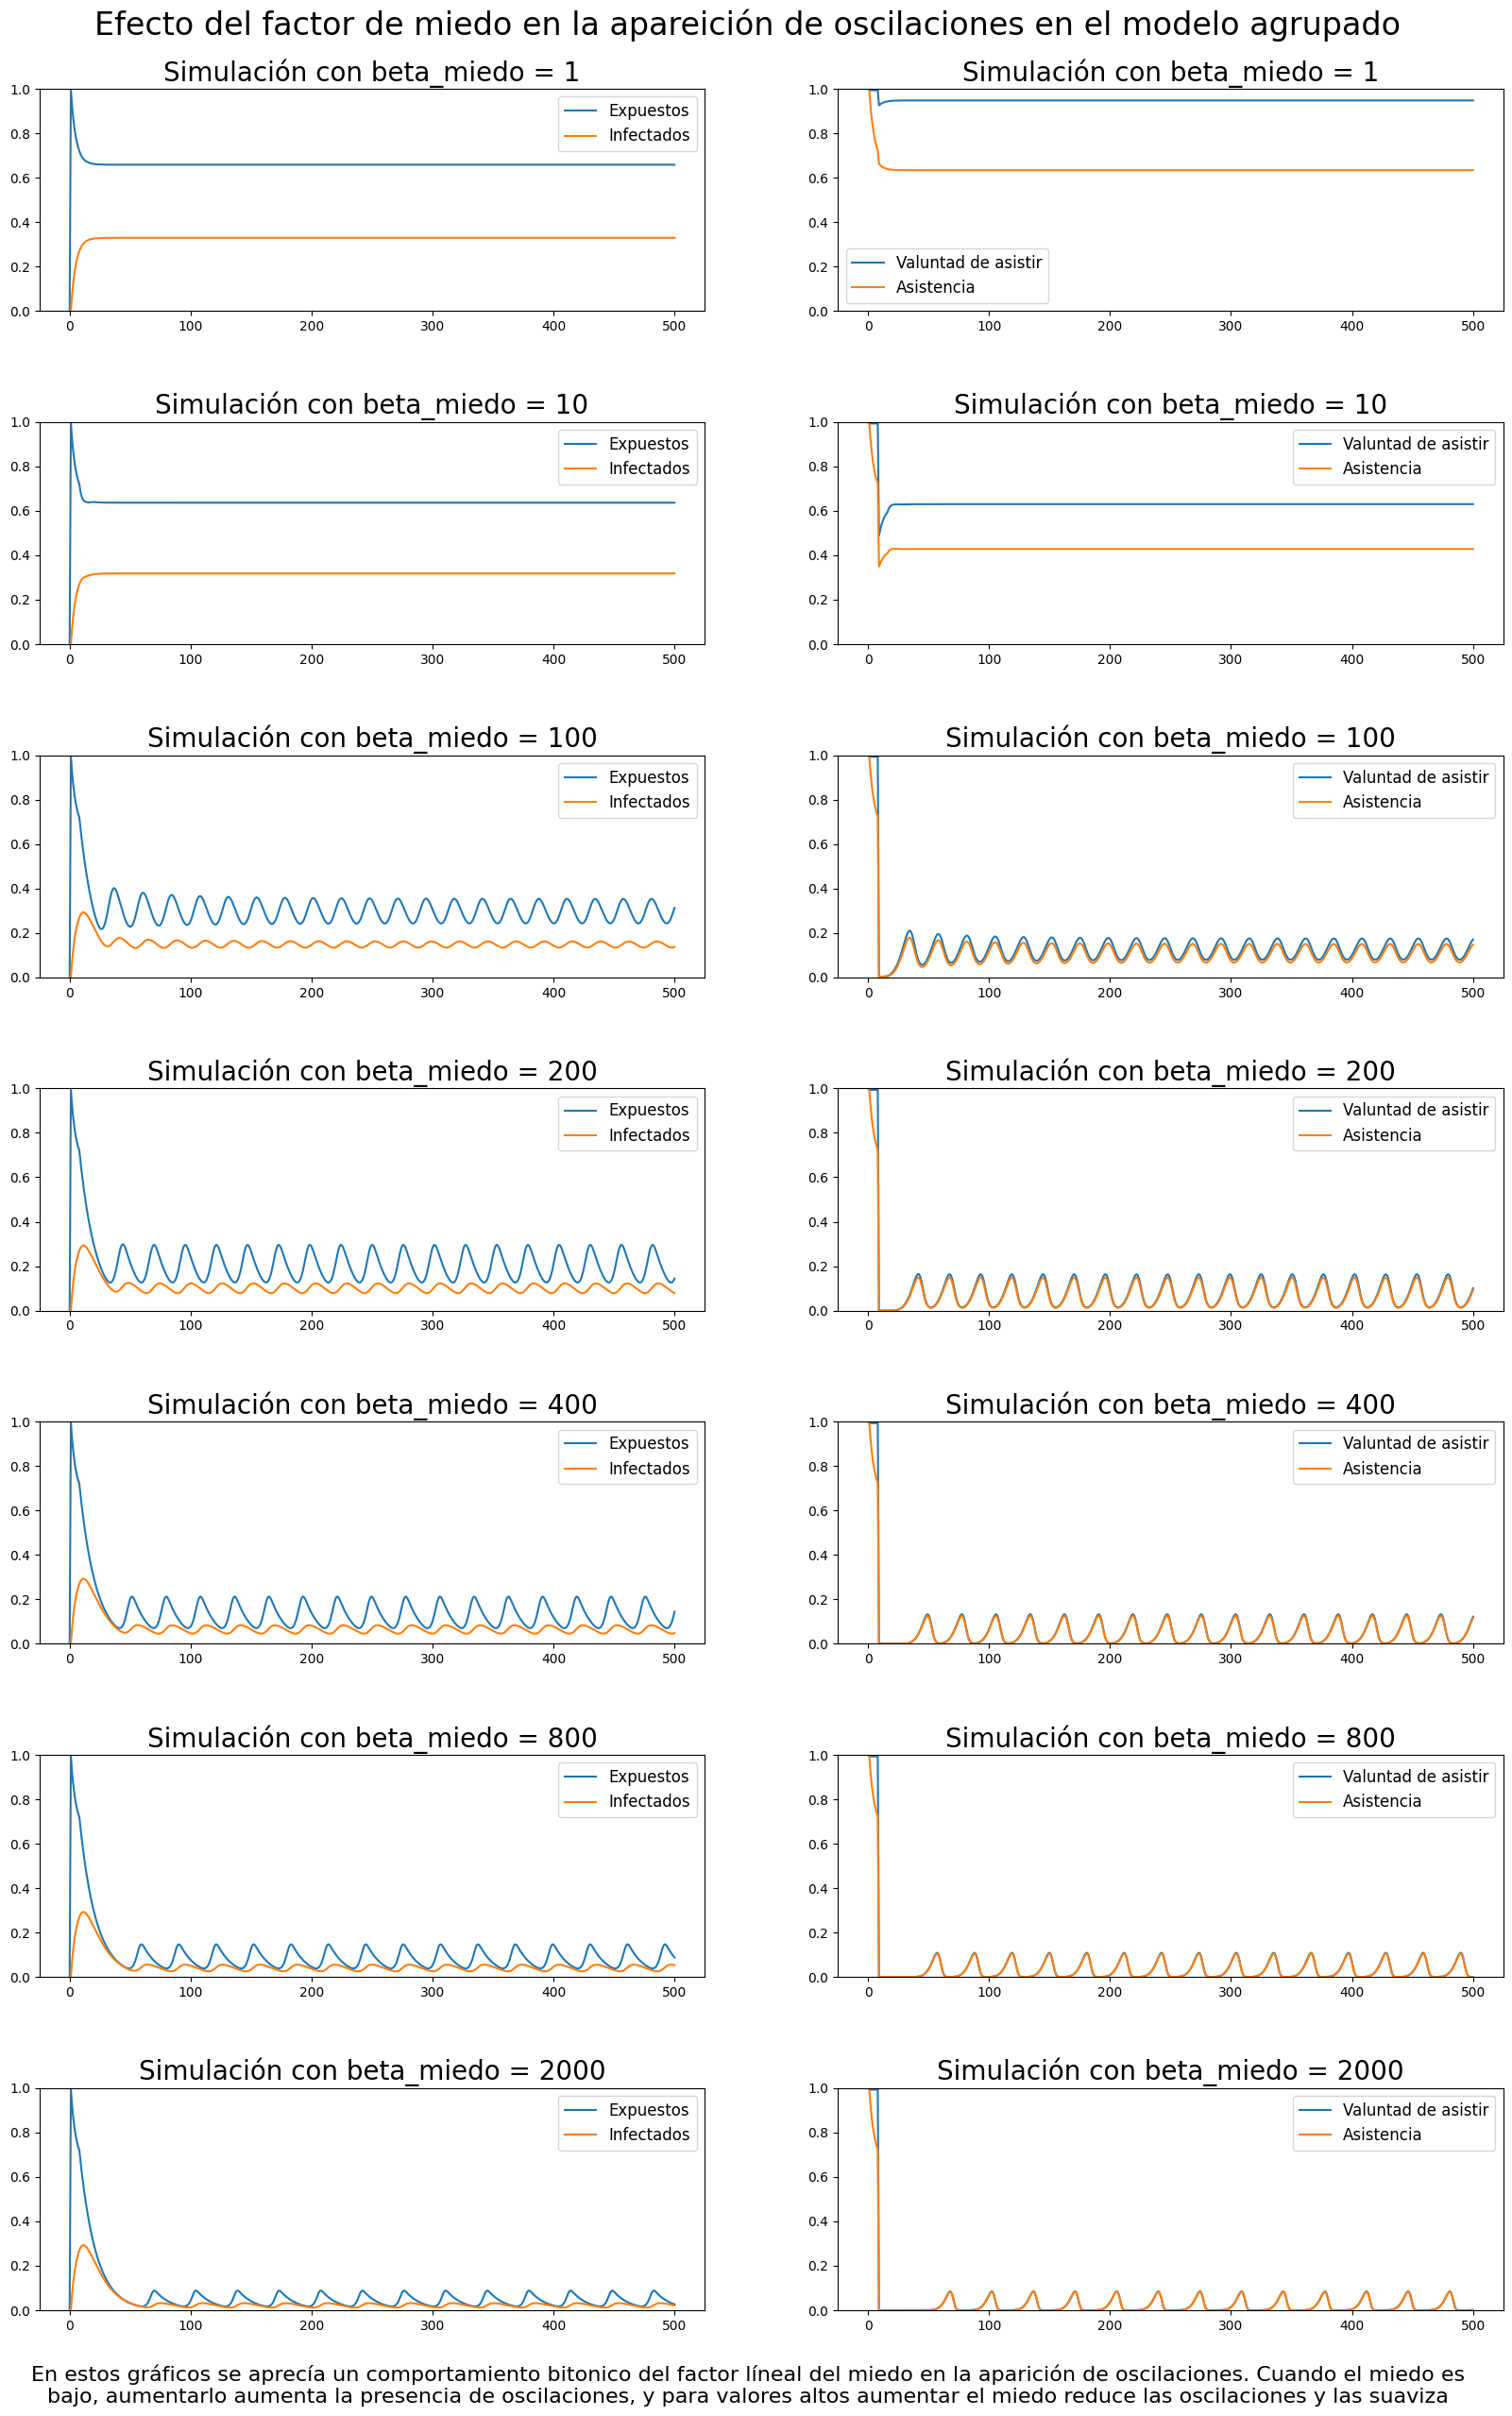

In [61]:
fig, ax = plt.subplots(nrows=len(betas_miedo), ncols=2, figsize=(20, 4 * len(betas_miedo)), gridspec_kw={'hspace': 0.5})
descripcion = "En estos gráficos se aprecía un comportamiento bitonico del factor líneal del miedo en la aparición de oscilaciones. Cuando el miedo es bajo, aumentarlo aumenta la presencia de oscilaciones, y para valores altos aumentar el miedo reduce las oscilaciones y las suaviza"
descripcion = textwrap.fill(descripcion, width=140)
fig.suptitle('Efecto del factor de miedo en la apareición de oscilaciones en el modelo agrupado', fontsize=24)
fig.text(0.5, 0.075,descripcion , ha='center', fontsize=16,)
fig.subplots_adjust(top=0.95)  # Adjust the top spacing
for i, resultado in enumerate(resultados_beta_miedo):
    PlotSimulacionAgrupada(ax[i, 0], ax[i, 1], *resultado)
plt.show()

### Escenarios variando $\alpha_{miedo}$

Parámetros fijos

In [62]:
probs = [0.9, 0.7, 0.5, 0.3, 0.1, 0.1, 0.1, 0.1]
prob_inicial = 1e-6
etoi = 1/14
itos = 1/7
memoria = 0
info_global = True
beta_miedo = 10
beta_contagio = 1
n_dias = 500

In [63]:
def Generar_Escenario_Alfa_Miedo(alfa_miedo):
    simulacion = SimulacionAgrupada(probs, etoi, itos, prob_inicial, gen_fun_miedo(memoria, alfa_miedo, beta_miedo), gen_fun_contagio(beta_contagio), info_global)
    simulacion.AvanzarHastaT(n_dias)
    titulo = f"Simulación con alfa_miedo = {alfa_miedo}"
    return titulo, simulacion

In [64]:
alfas_miedo = [0.1, 0.25, 0.5, 1, 1.5, 2, 3]
np.random.seed(123456)
resultados_alfa_miedo = [Generar_Escenario_Alfa_Miedo(alfa_miedo) for alfa_miedo in alfas_miedo]

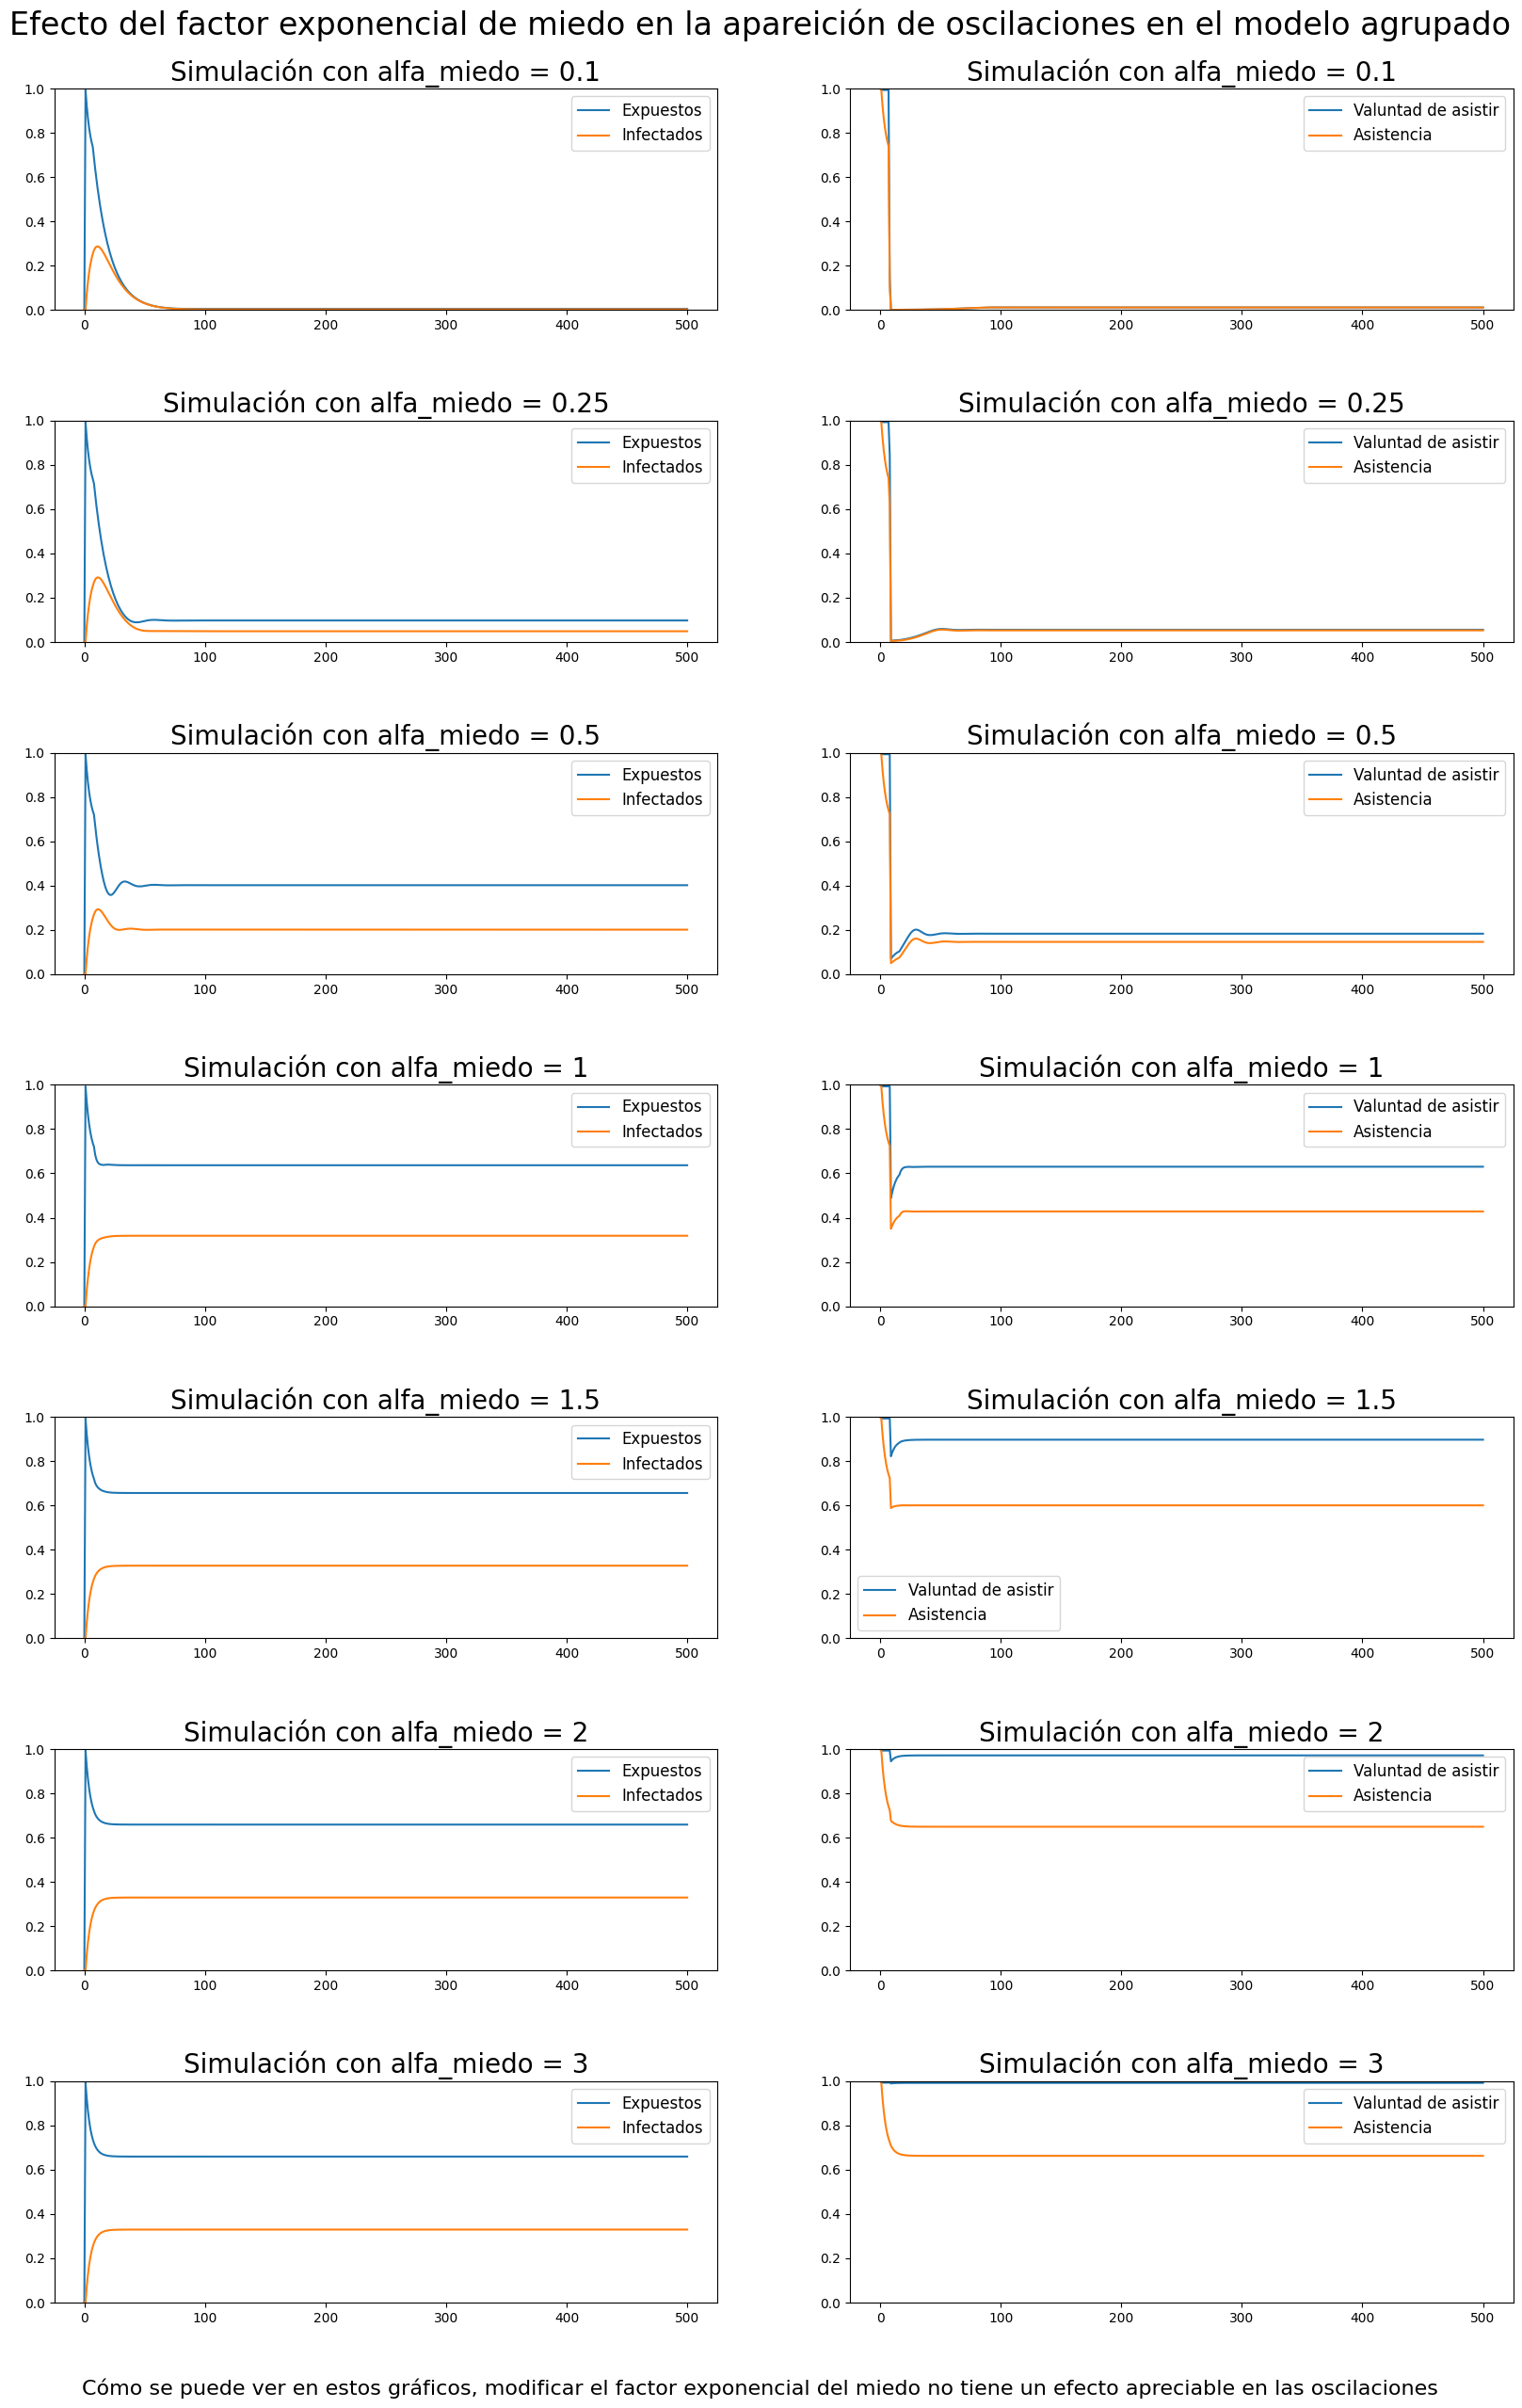

In [65]:
fig, ax = plt.subplots(nrows=len(alfas_miedo), ncols=2, figsize=(20, 4 * len(alfas_miedo)), gridspec_kw={'hspace': 0.5})
descripcion = "Cómo se puede ver en estos gráficos, modificar el factor exponencial del miedo no tiene un efecto apreciable en las oscilaciones"
descripcion = textwrap.fill(descripcion, width=140)
fig.suptitle('Efecto del factor exponencial de miedo en la apareición de oscilaciones en el modelo agrupado', fontsize=24)
fig.text(0.5, 0.075,descripcion , ha='center', fontsize=16,)
fig.subplots_adjust(top=0.95)  # Adjust the top spacing
for i, resultado in enumerate(resultados_alfa_miedo):
    PlotSimulacionAgrupada(ax[i, 0], ax[i, 1], *resultado)
plt.show()

### Incorporar la memoria

La memoria puede tener 2 impactos:
* Crear oscilaciones donde no las hay.
* Eliminar las oscilaciones donde las hay.

In [66]:
probs = [0.9, 0.7, 0.5, 0.3, 0.1, 0.1, 0.1, 0.1]
prob_inicial = 1e-6
etoi = 1/14
itos = 1/7
info_global = True
alfa_miedo = 1
beta_miedo = 400
beta_contagio = 1
n_dias = 500

### Crear oscilaciones

In [67]:
beta_miedo = 10

In [68]:
def Generar_Escenario_Memoria(memoria):
    simulacion = SimulacionAgrupada(probs, etoi, itos, prob_inicial, gen_fun_miedo(memoria, alfa_miedo, beta_miedo), gen_fun_contagio(beta_contagio), info_global)
    simulacion.AvanzarHastaT(n_dias)
    titulo = f"Simulación con memoria = {memoria}"
    return titulo, simulacion

In [69]:
memorias = [0, 0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 0.99]
np.random.seed(123456)
resultados_memoria = [Generar_Escenario_Memoria(memoria) for memoria in memorias]

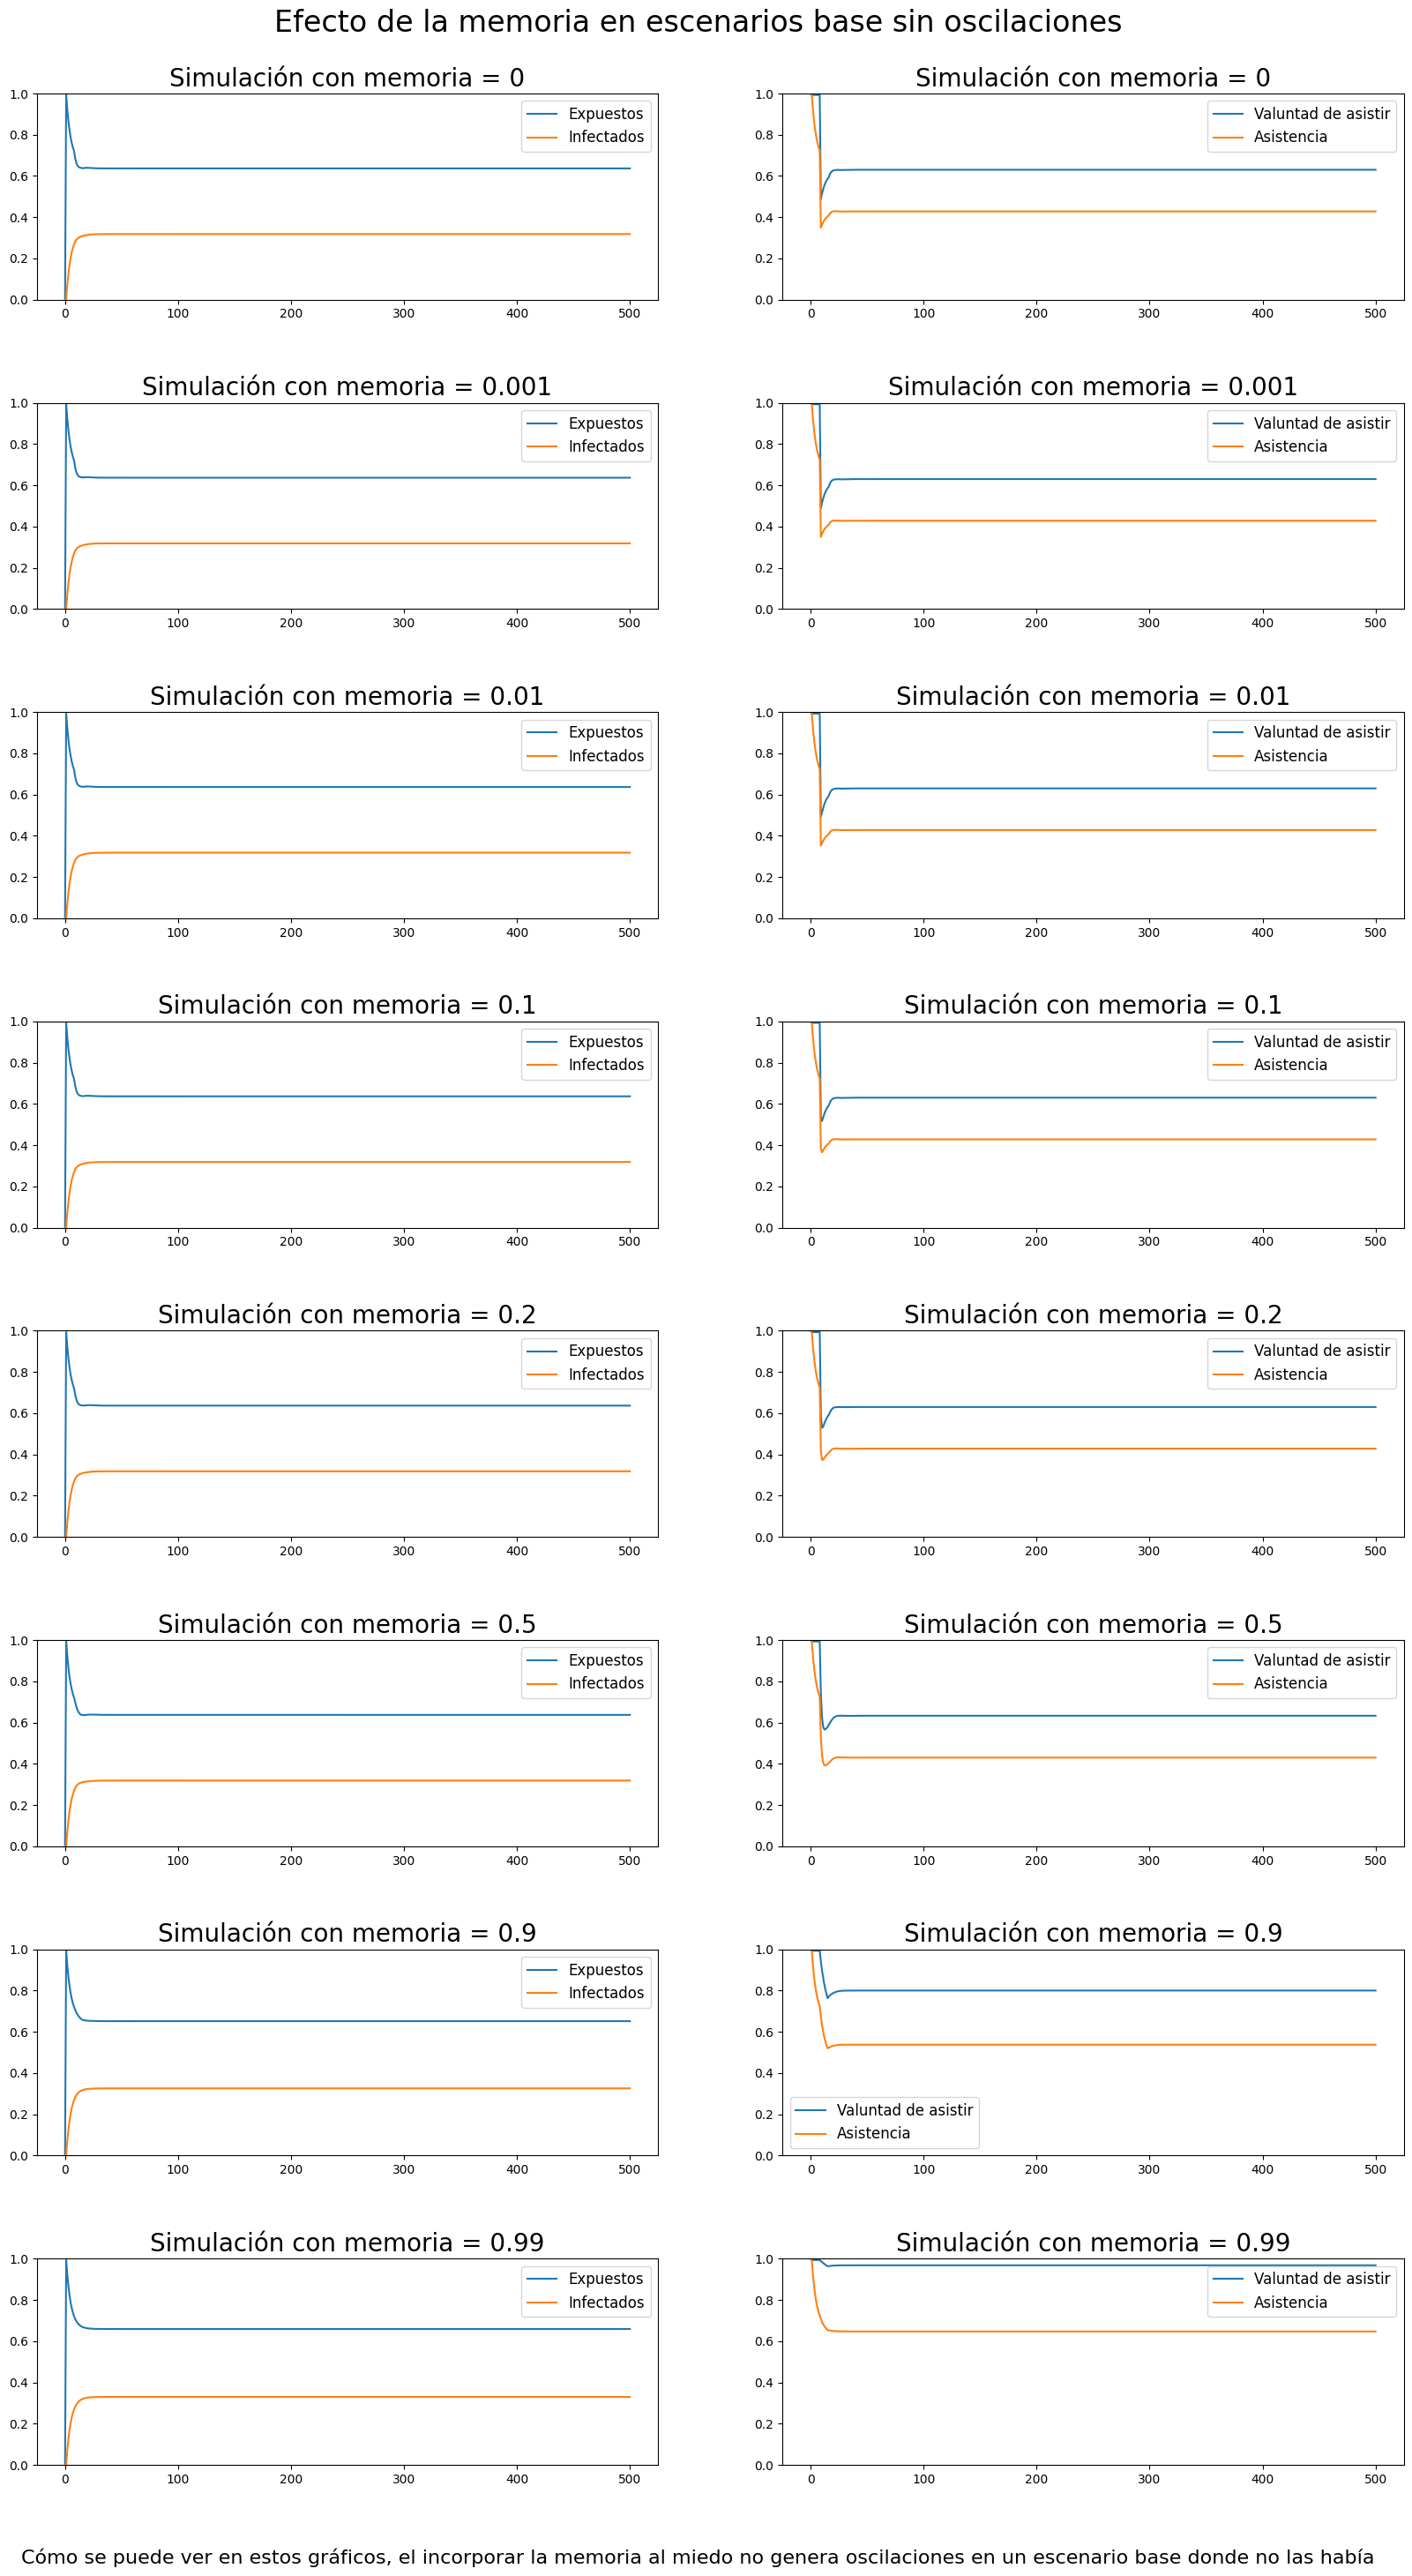

In [70]:
fig, ax = plt.subplots(nrows=len(memorias), ncols=2, figsize=(20, 4 * len(memorias)), gridspec_kw={'hspace': 0.5})
descripcion = "Cómo se puede ver en estos gráficos, el incorporar la memoria al miedo no genera oscilaciones en un escenario base donde no las había"
descripcion = textwrap.fill(descripcion, width=140)
fig.suptitle('Efecto de la memoria en escenarios base sin oscilaciones', fontsize=24)
fig.text(0.5, 0.075,descripcion , ha='center', fontsize=16,)
fig.subplots_adjust(top=0.95)  # Adjust the top spacing
for i, resultado in enumerate(resultados_memoria):
    PlotSimulacionAgrupada(ax[i, 0], ax[i, 1], *resultado)
plt.show()

### Cuando ya hay oscilaciones

In [71]:
beta_miedo = 400

In [72]:
memorias = [0, 0.001, 0.01, 0.1, 0.2, 0.5, 0.9, 0.99]
np.random.seed(123456)
resultados_memoria_2 = [Generar_Escenario_Memoria(memoria) for memoria in memorias]

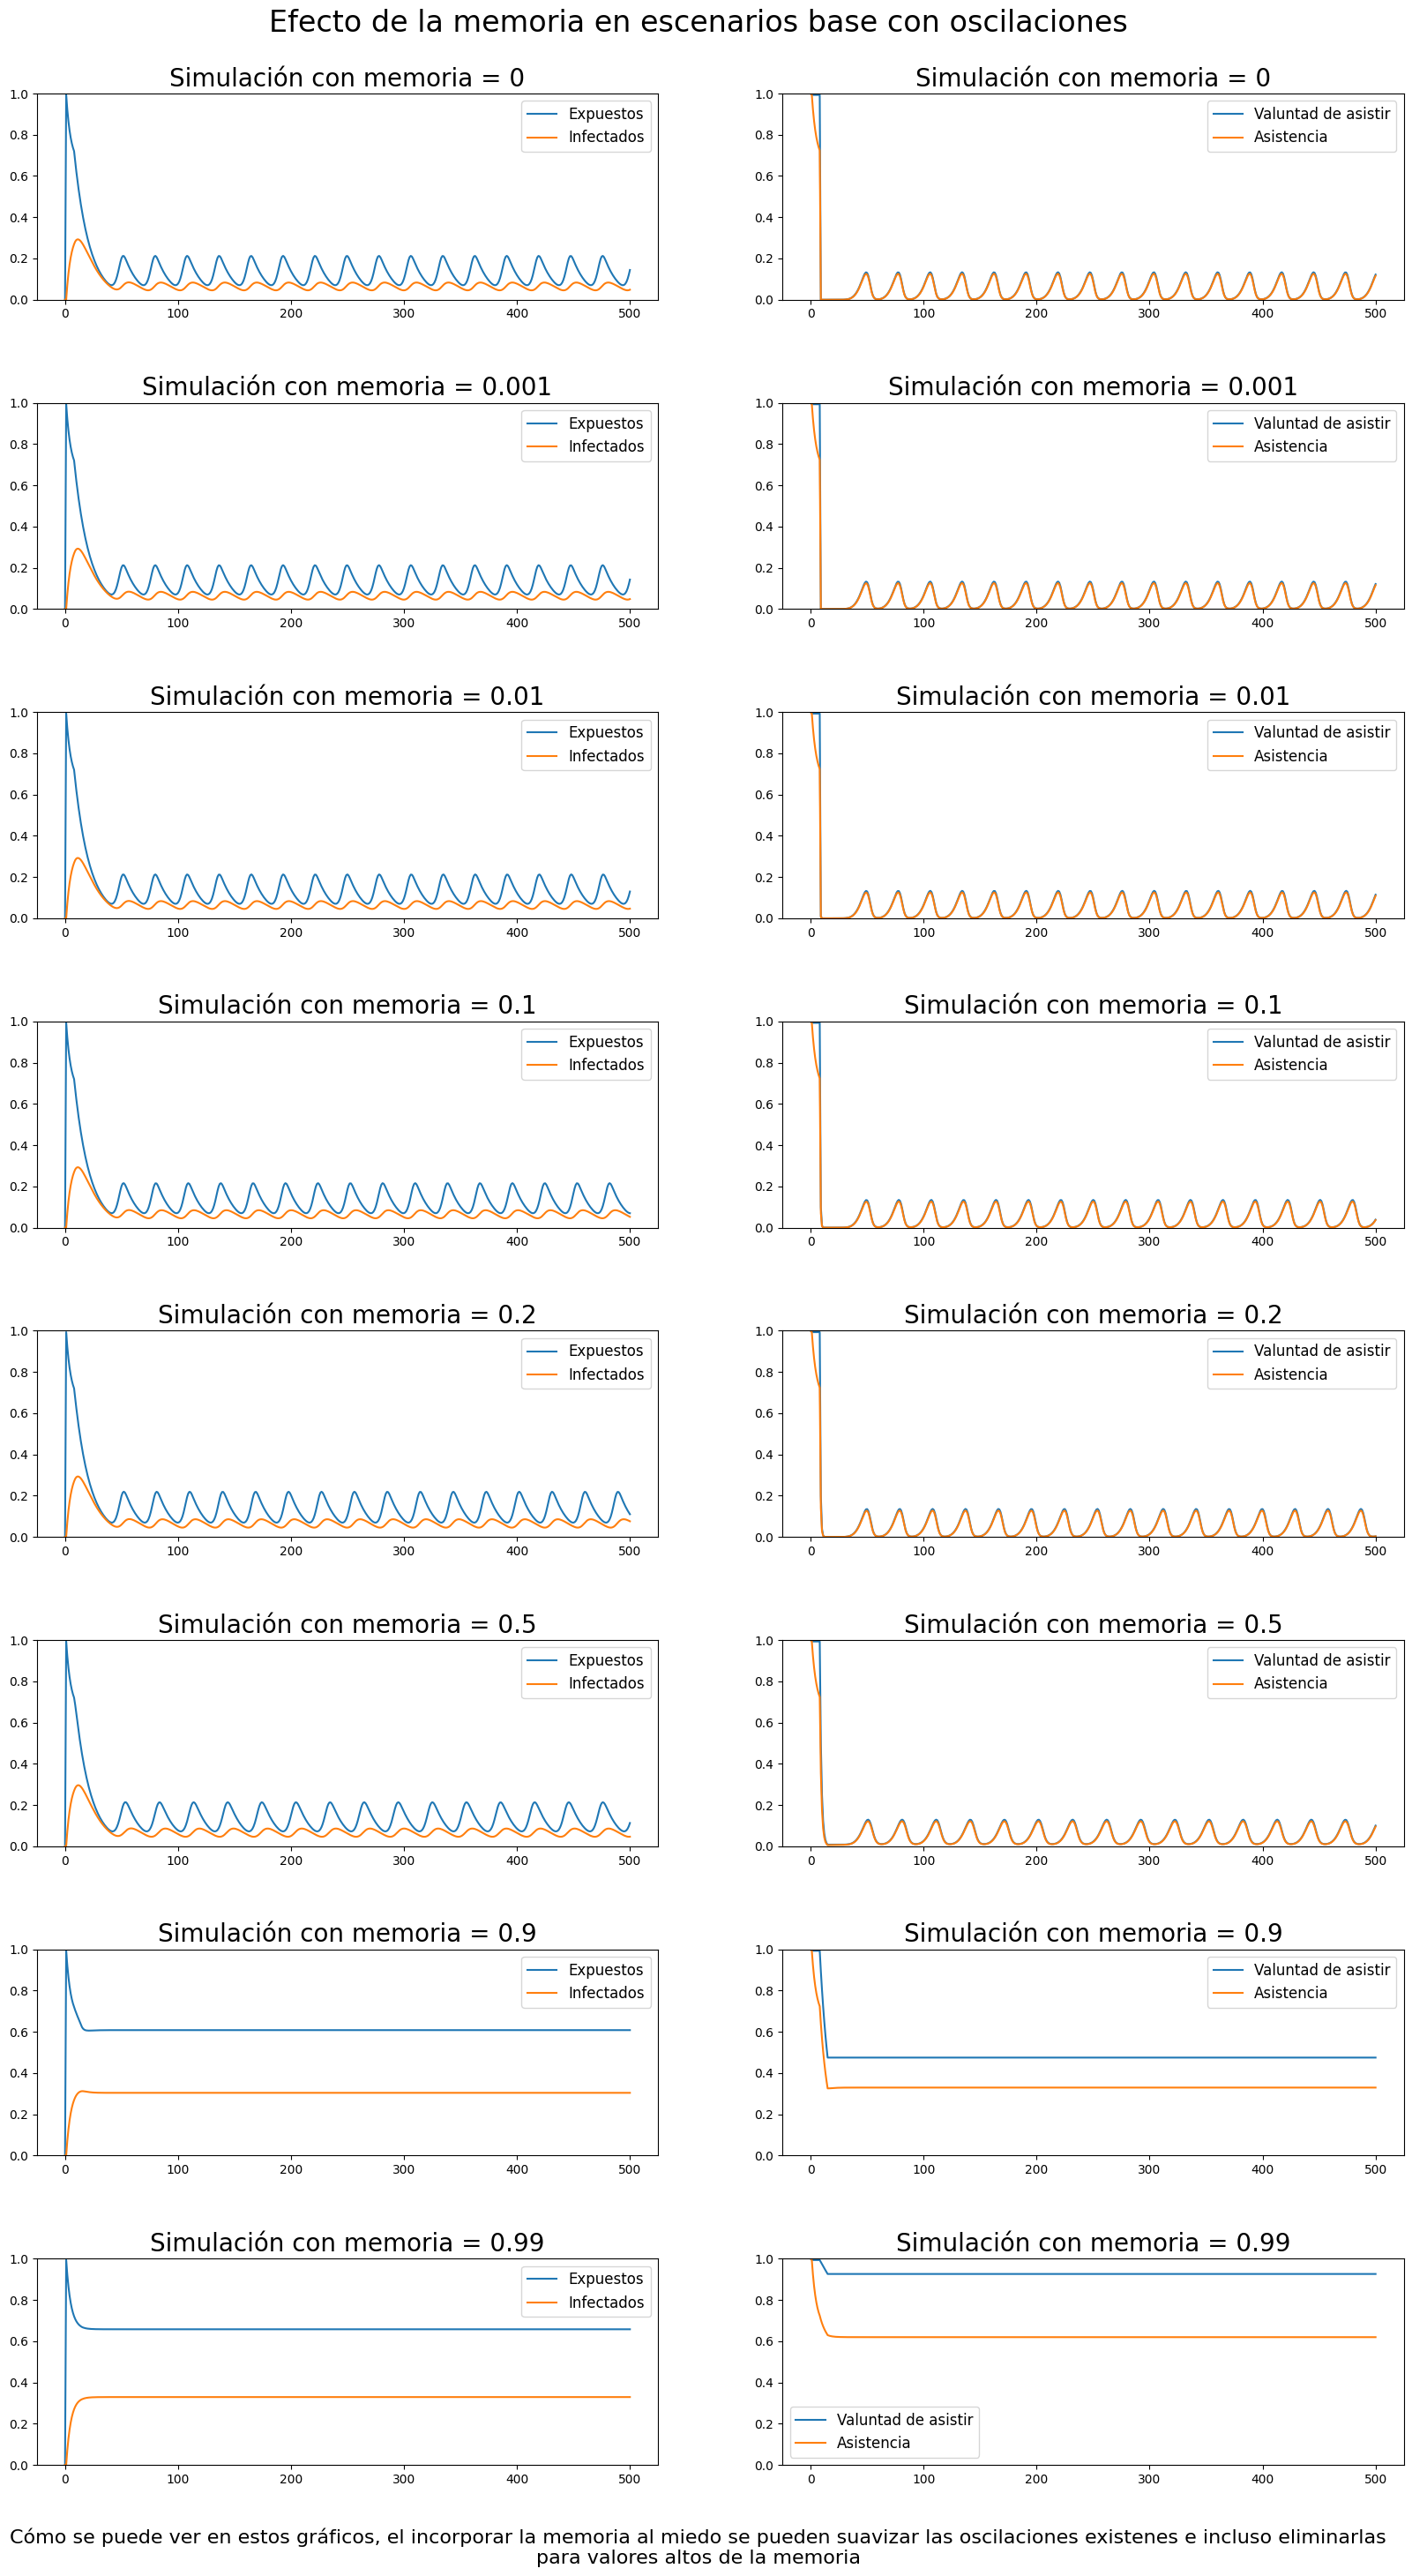

In [73]:
fig, ax = plt.subplots(nrows=len(memorias), ncols=2, figsize=(20, 4 * len(memorias)), gridspec_kw={'hspace': 0.5})
descripcion = "Cómo se puede ver en estos gráficos, el incorporar la memoria al miedo se pueden suavizar las oscilaciones existenes e incluso eliminarlas para valores altos de la memoria"
descripcion = textwrap.fill(descripcion, width=140)
fig.suptitle('Efecto de la memoria en escenarios base con oscilaciones', fontsize=24)
fig.text(0.5, 0.075,descripcion , ha='center', fontsize=16,)
fig.subplots_adjust(top=0.95)  # Adjust the top spacing
for i, resultado in enumerate(resultados_memoria_2):
    PlotSimulacionAgrupada(ax[i, 0], ax[i, 1], *resultado)
plt.show()

## 5. Consideraciones a futuro:

Durante la realización de estos modelos, surgieron ideas que no llegamos a incluir consideramos interesante mencionarlas.

1- Un aspecto que pensamos que valdría la pena explorar sería la evolución del sistema considerando la posibilidad de que los negocios puedan quebrar si luego de una determinada cantidad de días, la asistencia no supera un cierto porcentaje; para poder estudiar el efecto que tendría en el ecosistema luego de finalizada la epidemia.


2- Considerar un escenario más realista podríamos incorporar nacimientos y decesos al modelo, para poder evaluar la tendencia poblacional con distintos parámetros y estudiar posibles tendencias emergentes.


